# Table of Contents <a id='top'></a>
[Selenium Scraping](#scraping)  
[Data Cleaning](#datacleaning)  
[Sentiment Analysis](#sentiment)  
[Word2Vec](#w2v)  
[NMF Topic Extraction](#nmf)  
[Appendix](#appendix)  



**Python imports**

In [3]:
#Selenium is a web browser testing automation tool
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time


import os
# mv chrome driver from Downloads to Applications 
chromedriver = "/Applications/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

In [461]:
import pickle
import os
from collections import Counter

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [467]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.util import ngrams
from textblob import TextBlob
from collections import Counter
from operator import itemgetter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
from gensim import corpora, models, similarities, matutils
import gensim
from sklearn.decomposition import NMF

from sklearn.manifold import TSNE

In [8]:
from googletrans import Translator

# Web Scraping <a id='scraping'></a>
Scraped the Whisper webpage using Selenium to grab 11,620 links and Scrapy to crawl all of them  
[Back to Top](#top)

In [9]:
# driver = webdriver.Chrome(chromedriver)
# driver.get("http://whisper.sh/stories")

The script below will continue to scroll down the webpage and grab additional links as they appear. As new links appear, they get appended to a list. The list gets saved to a pickle which will be read by the scrapy spider.

In [120]:
# SCROLL_PAUSE_TIME = 3
# story_selector = '//a[@data-ga-label="story index row title"]'
# storyURLs=[]
# c=0
# # Get scroll height
# last_height = driver.execute_script("return document.body.scrollHeight")

# while True:
#     print(len(storyURLs))
    
#     # Add the additional URLs to the list
#     for storylinks in driver.find_elements_by_xpath(story_selector)[c:]:
#         storyURLs.append(storylinks.get_property('href'))
    
#     # Scroll down to bottom
#     driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#     c=len(storyURLs)
    
#     # Pickle the latest progress
#     with open('storyURLs2.pkl', 'wb') as picklefile:
#         pickle.dump(storyURLs, picklefile)
        
#     # Wait to load page
#     time.sleep(SCROLL_PAUSE_TIME)

#     # Calculate new scroll height and compare with last scroll height
#     new_height = driver.execute_script("return document.body.scrollHeight")
#     if new_height == last_height:
#         break
#     last_height = new_height

## Loading data from scrapy

In [39]:
df = pd.read_json('secrets.json',orient='records')

# Data Cleaning <a id='datacleaning'></a>

In [548]:
# pickle.dump(df, open( "df.pkl", "wb" ) )
# df = pickle.load( open( "df.pkl", "rb" ) )

In [10]:
df.head(5)

,title,secrets,neg,neu,pos,compound
0,16 Scandalous Twin Secrets That Will Make You ...,"if you ever feel stupid, remember that one tim...",0.195,0.805,0.000,-0.5267
1,16 Scandalous Twin Secrets That Will Make You ...,my grandma is a twin my mom is a twin i am a t...,0.000,0.782,0.218,0.6948
2,16 Scandalous Twin Secrets That Will Make You ...,my twin sister and i have switched places for ...,0.000,1.000,0.000,0.0000
3,16 Scandalous Twin Secrets That Will Make You ...,if i had a twin that was born like 5 minutes a...,0.000,0.912,0.088,0.3612
4,16 Scandalous Twin Secrets That Will Make You ...,my twin sister once opened a door for her refl...,0.000,1.000,0.000,0.0000


In [11]:
df.shape

(34241, 6)

In [40]:
df=df.set_index('title')

In [41]:
# Extracting the lists of secrets into separate rows
df=(df.secrets.apply(pd.Series)
              .stack()
              .reset_index(level=1, drop=True)
              .to_frame('secrets'))

In [545]:
print(df.shape)
df.drop_duplicates(subset='secrets',inplace=True)
df.reset_index(drop=True,inplace=True)
print(df.shape)

(34225, 6)
(34225, 6)


In [43]:
df.reset_index(inplace=True)

In [44]:
df.secrets=df.secrets.str.replace('\n',' ')
df.secrets=df.secrets.str.replace('  ',' ')
df.secrets=df.secrets.str.replace('athiest','atheist')
#df.secrets=df.secrets.replace(value='',regex=u"\U0001F6"+"\w{3}")
df.secrets=df.secrets.replace(value='',regex=u"\U0001F600").replace(value='',regex=u"\U0001F602")
df.secrets=df.secrets.str.lower()

In [547]:
df.head()

,title,secrets,neg,neu,pos,compound
0,16 Scandalous Twin Secrets That Will Make You ...,"if you ever feel stupid, remember that one tim...",0.195,0.805,0.000,-0.5267
1,16 Scandalous Twin Secrets That Will Make You ...,my grandma is a twin my mom is a twin i am a t...,0.000,0.782,0.218,0.6948
2,16 Scandalous Twin Secrets That Will Make You ...,my twin sister and i have switched places for ...,0.000,1.000,0.000,0.0000
3,16 Scandalous Twin Secrets That Will Make You ...,if i had a twin that was born like 5 minutes a...,0.000,0.912,0.088,0.3612
4,16 Scandalous Twin Secrets That Will Make You ...,my twin sister once opened a door for her refl...,0.000,1.000,0.000,0.0000


In [46]:
def keyword_search(keyword):
    idx=df[df['secrets'].str.contains(keyword)].secrets.index
    s=df[df['secrets'].str.contains(keyword)].secrets.values
    print('Num Secrets',len(s))
    l=list(zip(idx,s))
    for i in range(len(l)):
        print(l[i])

In [455]:
keyword_search('ugly')

Num Secrets 135
(114, "so i overheard my bestfriend and her boyfriend talking and he said i'm considered the 'ugly' friend because i'm the only plus sized one and i haven't had a boyfriend")
(144, "i like being ugly because nobody wants to sit next to you on the bus, nobody wants to date you so you don't have the stress of another person. profits of being ugly")
(145, 'i like being ugly, it makes dating hardmode. which i think is fun. plus it means i actually have to be worth something lmao')
(148, 'sometimes i like being ugly bc then that makes other girls feel good about themselves.')
(149, "sick of society's obsession with being pretty i like being ugly it's me")
(194, "only been in one wedding and i was a junior bridesmaid and the grooms sister(who wasn't in the wedding) told me i was too ugly to be standing up there with her and her brother. i punched her.")
(845, "i'm a straight guy, and i get my eyebrows waxed because i think unibrows are incredibly ugly.")
(869, "i'm pregnant, 

# Sentiment Analysis <a id='sentiment'></a>
[Back to Top](#top)

In [316]:
values=df.secrets.values

In [24]:
len(values)

34241

In [317]:
# {'neg': 0.195, 'neu': 0.805, 'pos': 0.0, 'compound': -0.5267}
neg=[]
neu=[]
pos=[]
comp=[]

analyzer = SentimentIntensityAnalyzer()
for sentence in values:
    vs = analyzer.polarity_scores(sentence)
    _1,_2,_3,_4=vs.values()
    neg.append(_1)
    neu.append(_2)
    pos.append(_3)
    comp.append(_4)
    
df['neg'],df['neu'],df['pos'],df['compound'] =neg,neu,pos,comp

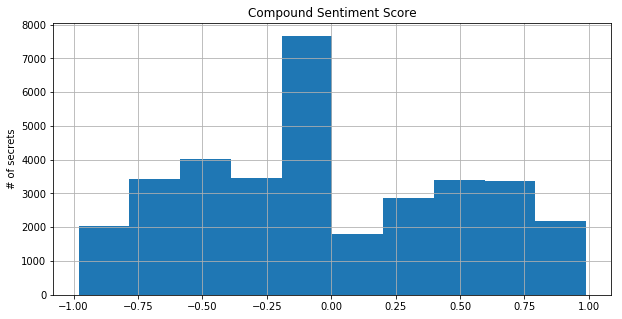

In [747]:
df['compound'].hist(figsize=(10,5))
plt.title('Compound Sentiment Score')
plt.ylabel('# of secrets')

In [60]:
df['compound'].mean()

-0.011897178820711797

In [670]:
pos_df=df[df['compound']>0]
neg_df=df[df['compound']<0]

In [671]:
pos_idx=[int(i) for i in pos_df.index.values]
neg_idx=[int(i) for i in neg_df.index.values]

Note: Textblob sentiment analysis was not working well for this dataset. Used Vader Sentiment Analysis instead

In [977]:
# pol=[]
# subj=[]
# for doc in values:
#     p,s = TextBlob(doc).sentiment
#     pol.append(p)
#     subj.append(s)
# df['polarity']=pol
# df['subjectivity']=subj

In [22]:
# df.polarity.hist()

In [1794]:
#  df[df.polarity>0].iloc[9]

In [13]:
keyword_search('going to a conce')

Num Secrets 1
(5646, 'i was going to a concert in phoenix and i took allergy pills. they caused me to pass out... i was knocked out for the entire concert😑')


# Initial Processing/EDA

In [321]:
# setting up stop words
stop = stopwords.words('english')
stop += stopwords.words('spanish')
stop += list(ENGLISH_STOP_WORDS)
# stop += ['.', ',', '(', ')', "'", '"','ve','like','got','just','feel',\
#          'didn','said','told','don','ago','mean','care','think','going','really','went',\
#          'year','years','old','gave','keeps','know','tell','people','say','giving','want','met']
stop = set(stop)

In [383]:
# Preprocessing words by stemming and removing stopwords
lemma=nltk.stem.WordNetLemmatizer()

full_txtwords=[]
txtwords=[]
for doc in df.secrets.values:
    words = TextBlob(doc).words
    words = [lemma.lemmatize(w) for w in words if w not in stop]
    full_txtwords+=words
    txtwords.append(words)


In [385]:
# Joining words into sentences to be passed into Count Vectorizer/TFIDF
txt=[]
for i in range (len(txtwords)):
    txt.append(' '.join(txtwords[i]))

In [553]:
def get_slice(idx,txt):
    _=[]
    for i in idx:
        _.append(txt[i])
    return _

In [672]:
pos_txt=get_slice(pos_idx,txt)
neg_txt=get_slice(neg_idx,txt)

In [528]:
df.shape

(34225, 6)

In [384]:
# pickle.dump(txtwords, open( "txtwords.pkl", "wb" ) )
#txtwords = pickle.load( open( "txtwords.pkl", "rb" ) )

In [63]:
print('Approx words per secret: %.2f' %(len(full_txtwords)/df.shape[0]))
print('Percent Unique Words (excluding stopwords): %.2f' %(len(set(full_txtwords))/len(full_txtwords)))

Approx words per secret: 10.73
Percent Unique Words (excluding stopwords): 0.06


In [65]:
# CountVectorizer is a class; so `vectorizer` below represents an instance of that object.
vectorizer = CountVectorizer(ngram_range=(1,2),analyzer='word',max_df=.9,min_df=10)

CV = vectorizer.fit_transform(txt)

In [66]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=4,ngram_range=(1,3),
                                   stop_words=stop)
tfidf = tfidf_vectorizer.fit_transform(txt)

In [478]:
# Exploring most common bigrams

# counter = Counter()

# n = 5
# for words in txtwords:
#     bigrams = ngrams(words, n)
#     counter += Counter(bigrams)

In [479]:
# for phrase, count in counter.most_common(10):
#     print('%20s %i' % (" ".join(phrase), count))

# WordCloud

In [487]:
from wordcloud import WordCloud, STOPWORDS

In [489]:
wc_text = df.secrets.str.cat(sep=' ')

In [490]:
stopwords = set(STOPWORDS)
stopwords.update(stop)
stopwords.update(['say','one','said','really','told','alway','much','go','keep','sometime','look','got','know',\
                  'way','gave','talk','wanted','month','today','bad','year','old','going','need','better','asked','day',\
                 'thing','took','things','think','thought','week','make','feel',\
                 'little','good','use','used','anymore','believe','high','reason','felt','house','trying','hour','makes',\
                  'help','home','knew','called','sure','went','turn','come','actually','getting','saw','person','came','day',\
                 'year'])

In [491]:
wc_text[:100]

'if you ever feel stupid, remember that one time my twin brother forgot my birthday. my grandma is a '

(-0.5, 999.5, 499.5, -0.5)

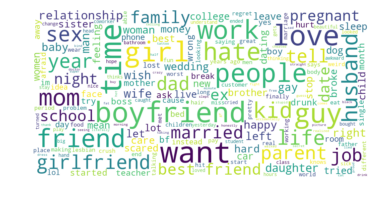

In [492]:
wordcloud = WordCloud(width=1000, height=500, max_font_size=90, background_color='white',collocations=True, stopwords=stopwords).generate(wc_text)
wordcloud.to_file("wc1.png")
plt.imshow(wordcloud, interpolation='bilinear')
# plt.figure(figsize=(8, 6))
plt.axis("off")

# Word2Vec Model <a id='w2v'></a>
[Back to Top](#top)

In [141]:
# pickling/unpickling w2v model

# with open('secretsW2V.pkl', 'wb') as picklefile:
#     pickle.dump(model, picklefile)

# with open('secretsW2V.pkl', 'rb') as picklefile:
#     w2vmodel=pickle.load(picklefile)

In [229]:
model = gensim.models.Word2Vec(txtwords, size=100, window=5, min_count=15, workers=2,sg=1)

In [69]:
def top_similar(model,keyword,n):
    words=[]
    similarities=[]
    m=model.wv.most_similar(keyword ,topn=n)
    for i in range(len(m)):
        word,similarity=m[i]
        words.append(word)
        similarities.append(similarity)
    tempdf=pd.DataFrame()
    tempdf['Words']=words
    tempdf['Similarities']=similarities
    return tempdf
        

In [72]:
# Exploring the word2vec in context
top_similar(model,'regret',10)

,Words,Similarities
0,divorcing,0.838984
1,settled,0.838776
2,happier,0.836596
3,prenup,0.828207
4,affair,0.825787
5,forced,0.822903
6,unhappy,0.818883
7,partner,0.814556
8,separated,0.813661
9,eloped,0.812957


In [ ]:
# keyword_search('pda')

In [32]:
list(model.wv.vocab.items())[:15]

[('feel', <gensim.models.keyedvectors.Vocab at 0x1a2ed60a90>),
 ('stupid', <gensim.models.keyedvectors.Vocab at 0x1a2ed60be0>),
 ('remember', <gensim.models.keyedvectors.Vocab at 0x1a2ed60e10>),
 ('time', <gensim.models.keyedvectors.Vocab at 0x1a2ed60748>),
 ('twin', <gensim.models.keyedvectors.Vocab at 0x1a2ed60a20>),
 ('brother', <gensim.models.keyedvectors.Vocab at 0x1a2ed60b00>),
 ('forgot', <gensim.models.keyedvectors.Vocab at 0x1a2ed60ac8>),
 ('birthday', <gensim.models.keyedvectors.Vocab at 0x1a2ed60dd8>),
 ('grandma', <gensim.models.keyedvectors.Vocab at 0x1a2ed60da0>),
 ('mom', <gensim.models.keyedvectors.Vocab at 0x1a2ed607b8>),
 ('gave', <gensim.models.keyedvectors.Vocab at 0x1a2ed60cf8>),
 ('birth', <gensim.models.keyedvectors.Vocab at 0x1a2ed60d68>),
 ("'m", <gensim.models.keyedvectors.Vocab at 0x1a2ed60f28>),
 ('happy', <gensim.models.keyedvectors.Vocab at 0x1a2ed60ba8>),
 ('sister', <gensim.models.keyedvectors.Vocab at 0x1a2ed60940>)]

In [ ]:
len(model.wv.vocab.items())

Words in vocab after removing stopwords: 34581
After additional preprocessing: 3129

In [480]:
from bokeh.plotting import figure, show, output_file
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

In [484]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    p = figure(tools=TOOLS)
    for i in range(len(x)):
        p.scatter(x[i], y[i], fill_alpha=0.6,
          line_color=None)
    
#         plt.scatter(x[i],y[i])
#         plt.annotate(labels[i],
#                      xy=(x[i], y[i]),
#                      xytext=(5, 2),
#                      textcoords='offset points',
#                      ha='right',
#                      va='bottom')
    show(p)

In [481]:
def display_closestwords_tsnescatterplot2(model, word):
    
    arr = np.empty((0,100), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    p = figure(tools=TOOLS)
    p.scatter(x_coords, y_coords, fill_alpha=0.6,
          line_color=None)
    show(p)

#     for label, x, y in zip(word_labels, x_coords, y_coords):
#         plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
#     plt.xlim(x_coords.min()+25, x_coords.max()+25)
#     plt.ylim(y_coords.min()+25, y_coords.max()+25)
#     plt.title('Word2vec: '+word)
#     plt.show()

In [227]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,100), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+25, x_coords.max()+25)
    plt.ylim(y_coords.min()+25, y_coords.max()+25)
    plt.title('Word2vec: '+word)
    plt.show()

In [485]:
tsne_plot(model)

/Users/laurachen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


/Users/laurachen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  import sys
/Users/laurachen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/Users/laurachen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


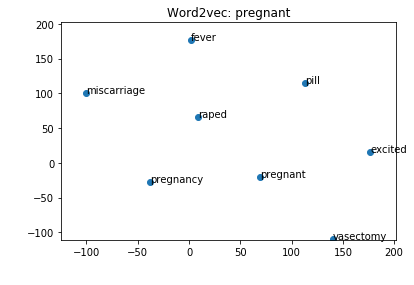

In [483]:
display_closestwords_tsnescatterplot(model, 'pregnant')

# NMF Topic Extraction <a id='nmf'></a>
[Back to Top](#top)

In [685]:
# setting up stop words
stopmore=list(stop)
stopmore += ['.', ',', '(', ')', "'", '"','ve','like','got','just','feel',\
         'didn','said','told','don','ago','mean','care','think','going','really','went',\
         'year','years','old','gave','keeps','know','tell','people','say','giving','want','come','look'\
             'met','girl','guy','ca','thing','wo','sure','today','life','need','good','time',\
             'best','room','way','thought','talk','love','boyfriend','girlfriend','wife','husband',\
            'man','woman','men','women','bf','gf','feeling','little','friend','relationship',\
            'hang','hour','month','day','age','week','instead','planning',\
            'ser','live','away','asked','wanted','came','chico','spend','felt','make','regret']
            #'mom','dad','daughter','son','sister','brother','met','make','college','christmas','called','getting']
stopmore = set(stopmore)

In [688]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=10,ngram_range=(1,3),
                                   stop_words=stopmore)
tfidf = tfidf_vectorizer.fit_transform(txt)
nmf = NMF(n_components=10, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [597]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [419]:
tfidf_vectorizer2 = TfidfVectorizer(max_df=0.85, min_df=20,ngram_range=(1,3),
                                   stop_words=stopmore)
tfidf2 = tfidf_vectorizer2.fit_transform(txt)
nmf2 = NMF(n_components=50, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf2)


In [687]:

print_top_words(nmf, tfidf_feature_names, 10)

Topic #0: mom, dad, family, parent, daughter, sister, home, single, brother, gay
Topic #1: sex, night, virgin, sex sex, sex night, gay, bed, better, orgasm, lesbian
Topic #2: work, job, bos, customer, home, food, bad, money, coworker, manager
Topic #3: ex, broke, cheated, new, break, night, dating, cheating, ex broke, left
Topic #4: hate, parent, job, look, bad, family, dating, hate job, brother, try
Topic #5: married, getting, wedding, getting married, marriage, divorce, married kid, engaged, young, money
Topic #6: kid, parent, child, wish, married kid, bad, mother, kid kid, hard, father
Topic #7: pregnant, baby, child, pregnant baby, birth, daughter, father, happy, scared, cheated
Topic #8: date, dating, second, second date, night, single, blind date, blind, crush, bad
Topic #9: school, high, job, high school, teacher, college, gay, student, parent, class



In [745]:
# NMF1 for interpretable topics
pred_topics=nmf.fit_transform(tfidf)

In [744]:
# NMF2 for DBSCAN testing and cosine similarity
pred_topics2=nmf2.fit_transform(tfidf2)

In [312]:
# pickle.dump(nmf2, open( "nmf2.pkl", "wb" ))
# pickle.dump(tfidf_vectorizer2, open( "nmf2.pkl", "wb" ))

In [749]:
# Function for website mockup

def similar_secrets(s,model,tfidf_vec,predictions):
    test_tfidf=tfidf_vec.transform([s])
    pred_test=model.transform(test_tfidf)
    l = cosine_similarity(pred_test,predictions)
    if sorted([(v,i) for i,v in enumerate(l[0])],reverse=True)[0][0]>.00001:
        for i in sorted([(v,i) for i,v in enumerate(l[0])],reverse=True)[:5]:
            print('<strong>Similarity: </strong> %.2f' %i[0])
            print('<br>')
            print('<strong>Secret: </strong>',df.iloc[i[1]].secrets)
            print('<br><br>')
    else:
        print('No matches found. Enjoy a random secret:')
        print(np.random.choice(random_secrets))


In [751]:
similar_secrets("i hate my ex for cheating on me",nmf2,tfidf_vectorizer2,pred_topics2)

<strong>Similarity: </strong> 0.91
<br>
<strong>Secret: </strong> i blackmailed my ex for two grand when i found out he was cheating on me
<br><br>
<strong>Similarity: </strong> 0.91
<br>
<strong>Secret: </strong> my ex (at the time, boyfriend) shared a photo of him cmg and came another mine comment, as if he was cheating her!
<br><br>
<strong>Similarity: </strong> 0.91
<br>
<strong>Secret: </strong> i sued my ex husband in court because whilst he was cheating on me, he gave me herpes. i won ✌🏻
<br><br>
<strong>Similarity: </strong> 0.91
<br>
<strong>Secret: </strong> i didn't know it then, but my ex boyfriend cheating on me was the best thing that ever happened to me. it lead me into the arms of the actual love of my life.
<br><br>
<strong>Similarity: </strong> 0.91
<br>
<strong>Secret: </strong> i walked in on my ex girlfriend cheating on me almost a year ago.. i still can't deal with it.. i've got trust issues now..
<br><br>


In [393]:
random_secrets=[]
for i in range(len(pred_topics)):
    if max(pred_topics[i]) < .00001:
        random_secrets.append(df.iloc[i].secrets)
print(len(random_secrets))

5107


In [473]:
print('% of secrets with low NMF coefficients:',5107/34241)

% of secrets with low NMF coefficients: 0.1491486814053328


In [381]:
def get_random(thresh,predictions):
    random_secrets=[]
    for i in range(len(predictions)):
        if max(predictions[i]) < thresh:
            random_secrets.append(df.iloc[i].secrets)
    print(len(random_secrets))
    print(random_secrets)
    

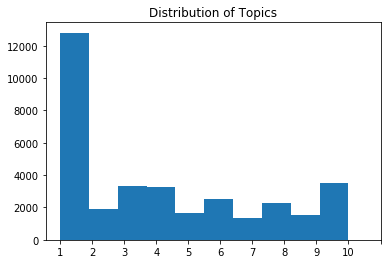

In [746]:
a=[list(i).index(max(i)) for i in pred_topics]
plt.hist(a)
plt.xticks(range(11),range(1,11))
plt.title('Distribution of Topics')

In [476]:
def check_nmf_topic(secret_num): 
    print(df.iloc[secret_num].secrets)
    print(sorted(enumerate(pred_topics[secret_num]),key=lambda t: t[1],reverse=True))

## Experimenting with NMF on Positive vs Negative sentiment

In [689]:
pos_tfidf = tfidf_vectorizer.transform(pos_txt)
pos_nmf = NMF(n_components=10, random_state=1,
          alpha=.1, l1_ratio=.5).fit(pos_tfidf)
print_top_words(pos_nmf, tfidf_feature_names, 10)
['Work','Sex','Wishes','Marriage','Happiness/Success','Parents','Improvements','Exes','Kids','Sexuality']


Topic #0: work, job, bos, free, help, customer, money, home, lol, pay
Topic #1: sex, night, amazing, better sex, sexy, making, lesbian, sex night, virgin, sex sex
Topic #2: wish, wish kid, wish knew, easier, white, knew, father, known, mother, different
Topic #3: married, getting, getting married, engaged, marriage, money, wedding, married money, married kid, flirt
Topic #4: happy, pregnant, pregnant happy, depression, job, parent, single, finally, actually, baby
Topic #5: mom, dad, parent, date, single, family, child, look, daughter, baby
Topic #6: better, look better, better sex, look, makeup, lie, treat, better job, drink, work better
Topic #7: ex, new, break, dating, cheated, broke, pregnant, fwb, ex break, rebound
Topic #8: kid, wish kid, kid kid, married kid, child, school, special, adult, parent, hard
Topic #9: gay, straight, act, lesbian, family, act gay, dad, accepted, closet, crush



['Work',
 'Sex',
 'Wishes',
 'Marriage',
 'Happiness/Success',
 'Parents',
 'Improvements',
 'Exes',
 'Kids',
 'Sexuality']

In [692]:
neg_tfidf = tfidf_vectorizer.transform(neg_txt)
neg_nmf = NMF(n_components=10, random_state=1,
          alpha=.1, l1_ratio=.5).fit(neg_tfidf)
print_top_words(neg_nmf, tfidf_feature_names, 10)
['Hate','Family','Breakups','Work','Fears','Cheating','Judgement','Sex','Pregnancy','Marriage/Kids']

Topic #0: hate, job, parent, hate job, family, look, hate hate, brother, try, parent hate
Topic #1: mom, dad, died, cheating, daughter, brother, family, sister, home, wedding
Topic #2: broke, ex, ex broke, heart, reason, break, cheating, new, broke heart, broke ex
Topic #3: work, job, customer, bos, fired, hard, money, sick, school, working
Topic #4: scared, scared death, afraid, night, death, lose, kissed, virgin, im scared, bos
Topic #5: cheated, ex cheated, cheated ex, ex, cheated pregnant, revenge, cheating, guilty, jail, deployed
Topic #6: bad, bad person, person, date, anxiety, leave, money, hurt, try, trump
Topic #7: sex, night, virgin, awkward, sex sex, weird, embarrassed, sex drive, drunk, bed
Topic #8: pregnant, baby, pregnant baby, birth, getting, pregnancy, abortion, father, trying, lied
Topic #9: kid, married, parent, child, getting, marriage, getting married, married kid, school, mother



['Hate',
 'Family',
 'Breakups',
 'Work',
 'Fears',
 'Cheating',
 'Judgement/Anxiety',
 'Sex',
 'Pregnancy',
 'Marriage/Kids']

In [675]:
# NMF1 for interpretable topics
posW=nmf.fit_transform(pos_tfidf)
negW=nmf.fit_transform(neg_tfidf)

In [676]:
# get_random(.00001,posW)

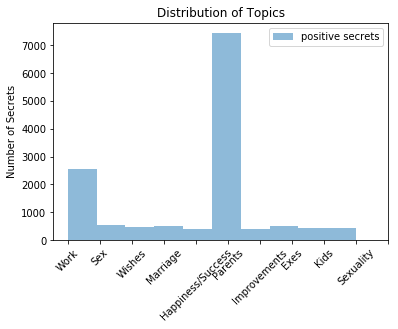

In [722]:
p=[list(i).index(max(i)) for i in posW]
n=[list(i).index(max(i)) for i in negW]
plt.hist(p,alpha=.5,label='positive secrets')
plt.xticks(range(11),['Work','Sex','Wishes','Marriage','Happiness/Success','Parents','Improvements','Exes','Kids','Sexuality'],\
           rotation=45)
plt.title('Distribution of Topics')
plt.ylabel('Number of Secrets')
plt.legend()

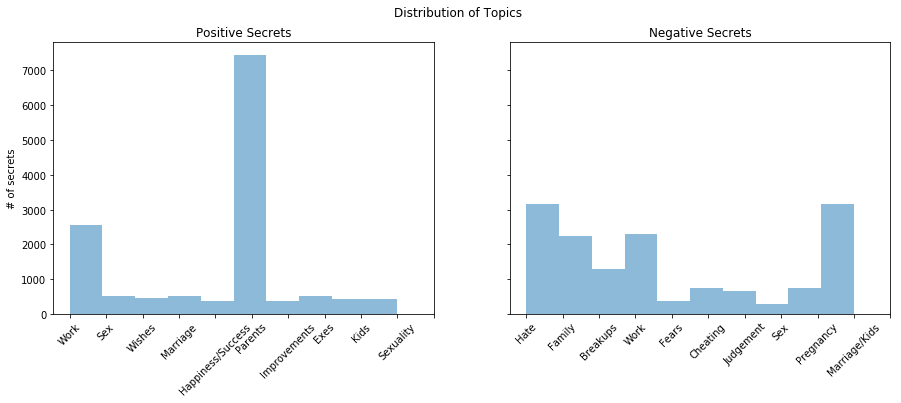

In [743]:
fig,ax=plt.subplots(1,2,sharey=True,figsize=(15,5))
p=[list(i).index(max(i)) for i in posW]
n=[list(i).index(max(i)) for i in negW]

plt.sca(ax[0])
plt.hist(p,alpha=.5,label='positive secrets')
plt.xticks(range(11),['Work','Sex','Wishes','Marriage','Happiness/Success','Parents','Improvements','Exes','Kids','Sexuality'],\
          rotation=45)
plt.title('Positive Secrets')
plt.ylabel('# of secrets')

plt.sca(ax[1])
plt.hist(n,alpha=.5,label='negative secrets')
plt.xticks(range(11),['Hate','Family','Breakups','Work','Fears','Cheating','Judgement','Sex','Pregnancy','Marriage/Kids'],\
          rotation=45)
plt.title('Negative Secrets')

plt.suptitle('Distribution of Topics')

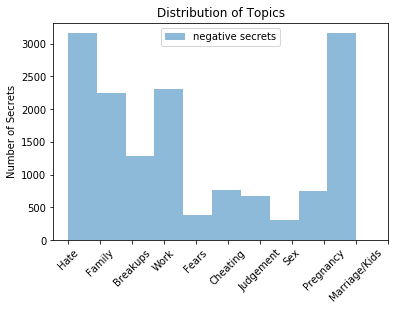

In [742]:
plt.hist(n,alpha=.5,label='negative secrets')
plt.xticks(range(11),['Hate','Family','Breakups','Work','Fears','Cheating','Judgement','Sex','Pregnancy','Marriage/Kids'],\
        rotation=45)
plt.title('Distribution of Topics')
plt.ylabel('Number of Secrets')
plt.legend()

# Appendix <a id='appendix'></a>
This section contains code for models that did not work well for the data. Clustering was ineffective due to the large amount of noise in the data.  
[Back to Top](#top)

# DBSCAN

In [361]:
from sklearn.cluster import DBSCAN

In [2093]:
_clusters=[]
noise=[]
for i in range(2,23,5):
    for j in np.linspace(.00005,.005,10):
        dbs=DBSCAN(eps=j, min_samples=i, metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=1)
        dbsc=dbs.fit_predict(pred_topics)
        _clusters.append((i,j,len([x for x in dbsc if x!=0 and x!=-1])))
        noise.append((i,j,len([x for x in dbsc if x==-1])))

In [2113]:
sorted(noise,key=lambda t:t[2],reverse=True)[0]

(22, 5.0000000000000002e-05, 24483)

In [368]:
dbs=DBSCAN(eps=.00005, min_samples=2, metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=1)

In [369]:
dbsc=dbs.fit_predict(pred_topics)

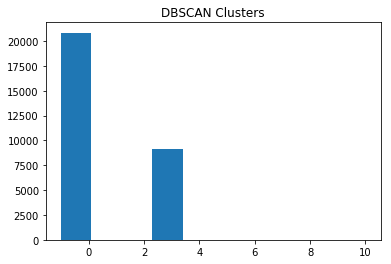

In [370]:
plt.hist(dbsc,bins=10,range=(-1,10))
plt.title('DBSCAN Clusters')

In [2201]:
len([x for x in dbsc if x==-1])

10604

In [96]:
set([x for x in dbsc if x<10])

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# MeanShift

In [1704]:
from sklearn.cluster import MeanShift

In [1705]:
ms= MeanShift(min_bin_freq=1)

In [1706]:
ms_clusters=ms.fit_predict(pred_topics)

array([  0,   0,   0, ..., 613,   0,   0])

In [1709]:
ms_clusters

In [1710]:
ms_clusters.shape

(34241,)

In [1716]:
Out[1710]

(34241,)

array([  0,   0,   0, ..., 613,   0,   0])

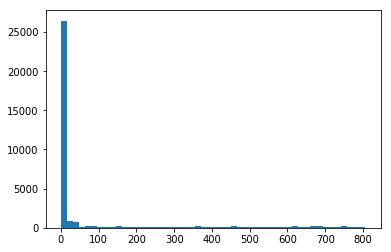

In [1741]:
plt.hist(ms_clusters,bins=50)
ms_clusters

# Kmeans

In [371]:
from sklearn.cluster import KMeans

In [372]:
km=KMeans(n_clusters=8,init='k-means++')

In [373]:
km_clusters=km.fit_predict(pred_topics)

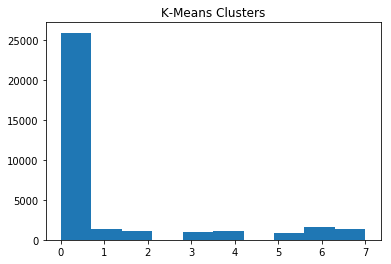

In [374]:
plt.hist(km_clusters)
plt.title("K-Means Clusters")

ideas 
exploring the "noise"  


In [102]:
def get_cluster(clusters,target):
    _=[]
    for i,c in enumerate(clusters):
        c = int(c)
        if c==target:
            _.append(i)
    print('Count of Cluster:',len(_))
    for j in _:
        print(df.iloc[j].secrets)

In [103]:
get_cluster(dbsc,3)

Count of Cluster: 9135
what's the creepiest thing you've done to spy on somebody?
sent a pic of me in my underwear to a group chat of 4 guys. was meant for my bff who was in the chat also to show her my new underwear. we had to spam the chat so they wouldn't see it. it worked
i sent a rant about my friend to that friend... i was not ready for confrontation so i told him it was about a 2 year old i was babysitting with the same name... he believed it
i was sexting with a guy i liked and accidentally sent a picture of me to my cousin instead (thank god she's is female and favorite cousin)
i was trying to put "inhales and chokes on gum" but auto correct changed "gum" to "him" oops
i was looking in the mirror. and the person in the mirror wasn't me.
i heard voices in my attic and when i went up to my room the attic door was open and we keep it locked
i get to spend valentines day getting my mugshot and fingerprints taken. yayyyy
the cops came to serve a warrant on me for missing court beca

i've dated a variety of men but still have a weakness for men in uniform...and accents. makes me melt every time!
recording songs off of the radio and stopping before the dj came on or the next song started...
how sexually confusing david bowie was with his codpiece in the labyrinth.
life before the internet
how to wind a cassette tape
that in the 80s not everyone dressed like what you see in the movies now days. not everyone wore neon and not everyone wore pigtails and chewed gum. not every chick smoked in the bathroom stall.
when i first met my boyfriend i never would have thought he would be mine...i still think it's too good to be true
the first time i met my boyfriend i thought he had a mental disability.
+de que se ríen los angelitos? -de que? + de la gracia de dios 💕
When they go to buy milk, do not choose the third, because the third is the expired one. BA dum tss
- What makes a puppy with a drill? -ta'ladrando
¿cómo se maldicen los pollitos? caldito seas 😅
my husband and i bui

i'm a psychologist... knowing what people mean through words is what i do 
i'm a psychologist and i feel like a hypocrite when i can't apply what i help my clients with to my own issues.
i feel like a failure because i'm training to be a psychologist and i have severe anxiety issues
i just saved my friend from committing suicide... i guess you could say i had a good day
i stopped my friend from suicide over text message.
estoy en una edad donde todos mis amigos se están casando. soy siempre el padrino y la tercera rueda. cuando voy a encontrar el amor?
acabo de ser invitado a ser dama de honor en la boda de una de mis mejores amigas. estaba esperando ser el padrino.
voy a ser padrino de boda por tercera vez este año. con todo ese amor en el aire, tal vez me enferme. no me han vacunado todavía.
hoy es la boda de mi hermana y soy el padrino. por qué mierda estoy tan nervioso?
acabo de llegar de la despedida de soltero de mi hermano. me di cuenta de que toda boda tiene un padrino gordo. t

i made a bet that my coworker would sleep with me on a business trip. i won
i gave a coworker a bj while on a business trip after he told me his wife hadn't given him one in years. i feel so much guilt now. i cannot let my husband find out.
what's your most awkward thanksgiving memory?
...i showed up on acid ...i think we had dinosaur and mashed pine cones from what i remember...
eating an olive for the first time and throwing up all over the table
ran into a wall multiple time to make her smile
i was rude to my friend to make him laugh... :/
sometimes when my girlfriend cries, i think she's faking it just to get my attention.
when girls start crying infront of me,i just feel i should run...😝
i'm a meninist. men want equality too
i'm a woman who believes in specific gender roles and male dominance. i'm 100% anti feminist and pro men's rights.
i'm a meninist. this means i'm against feminists that don't just want equality, but want advantage over men.
calculate her bonus after she denied

instead of cutting my chicken nugget in half, i gave him the whole chicken nugget instead.  true love. 
march madness upsets are the reason i have trust issues
my gf based her bracket off of uniform, appearance or mascot. i based mine off of what i thought was knowledge. she's kicking my ass
i'm teaching my 8 year old sister how to fill out a bracket. i feel so proud 
busty girl problems: going to bed in a tank top, and waking up with your boobs hanging out. -.-
once i take my bra off, don't ask me to do shit for you because once that bra comes off, i am clocked out. i am done. i am finished. i am logged the fuck out.
busty problems: when you can't buy clothes your size without the buttons threatening to pop
dear bra companies bra sizes over c do not need to be padded they're big enough as they are. 
chloe has big boobs. chloe doesn't post photos of her cleavage all over the media.  chloe is smart.  be like chloe. 
no quiero casarme porque veo el matrimonio como una cárcel en donde com

i'll never chase a man, but if he has tattoos and muscles a bitch might just power walk.
when my daughter asked why a man was staring at me today, i said "well, he doesn't like my tattoos", she turned to him and said "my daddy taught me not to judge, you should learn not to judge too!"
found one off the clearance rack on the first day that fit perfectly. i was relieved it was over with. i did really love the dress though.
transei com meu melhor amigo, mas se vc perguntar, nenhum dos dois vai admitir. nós não admitimos nem entre nós que aconteceu.
fiz sexo com meu melhor amigo e eme vez de me sentir culpada ou apaixonada, não sinto nada.
transei com um amigo hj... ele é muito legal e cairnhoso... mas o sexo foi muito ruim... não sei oq fazer agora...
fiz sexo com uma amigo meu e foi o melhor da minha vida! agora não sei como agir direito perto dele...
to the stranger in dunkin donuts who saw me crying with my suitcase and bought me a coffee: i was planing on killing myself and you prett

he trabajado para la misma compañía por 15 años y trabaje mi camino hacia el éxito. sangre, sudor y lágrimas. no tengo un título y soy una mamá soltera. estoy asustada porque nos cambiaron de compañía
a patron dined-and-dashed at my restaurant, so i ran after him in my waiter outfit. i was the one who almost got in trouble because we have a no chase policy fml.
i'm a camp counselor. i'll sit in the bathroom for 10mins, just to have some time to myself.
i'm a camp counselor and i prefer being in a unit with the older girls. it's fun to have conversations that don't solely revolve around disney. 
they had stronger feelings then me and it was causing stress
i don't need to be a size zero. i'm soccer strong. i love my muscle
i'm a girl soccer player. i don't mess around. you hurt me, watch out. i kick balls for a sport
forget the glass slippers this princess wears soccer cleats 
my life goal is to become a professional woman soccer player, i don't get a lot of support. but, i'll never stop

sometimes i just want to be a woman in the bedroom. i'm a guy...
i enjoy being a man, but sometimes i want to be a woman, just to know what's like.
sometimes i want to be a woman just to know how they feel
mi "mejor amiga" no es mi mejor amiga. ella ha sido mi novia desde hace dos años. 👭
I'm not interested in confessing, but if I did, it would probably be that I agreed to help someone commit suicide
que soy bisexual... 😓
this is my ftm transition.
trans is beautiful💋 before/present
came out of the closet for being a transsexual    before & after
2 years in the transition and still a long way to go.    #livingwhiletrans
when we were both sick, hadn't showered in 5 days and held eachothers hair back when we puked. i love him
i've been with my boyfriend for 3 years, and the "honeymoon phase" has proven to be permanent for us at this point 😁 its all about communication and keeping the romance going
randomly puked in some guys boot.. it was that or the floor.. then pretended i had no clue 

my sister in law is on life support in the icu i'm freaking out emotionally she is only 31
my girlfriend was put on life support this afternoon.. i'm in pieces 💔😭
i feel like a horrible sister my brother is on life support and i yelled at him the last time i talked to him before he ended up in the hospital
the only thing i'm worried about in regards to working on black friday is running into someone i know
he was a textbook narcissistic sociopath. treated me horribly no matter how great of a wife i was to him. i finally had enough
i sued my old employer because they were paying me less just because i was a woman, it happens
people often think my girlfriend and i are sisters. the only visual similarity between us is we both have blonde hair and are women.... must mean every blonde woman is my sister.
my jean back pocket activated the detector alarm at the airport. a guard publicly put his hand on my ass to make sure he did not hide anything. there is always something with me ...
me insp

i went to buy a gym membership and hire a personal trainer and the guy said "i can see why you're here." ouch. 
so i let my fiancé be my personal trainer, the first day we workout he said "welcome to death" ummmmmm ok 
i walked across a canyon on a wire. i fell off the wire and was hanging from my harness. it was amazing until i could only see the rocks i could plunge towards.
sky biking. i biked on a thin, yard long wire in mid air, with supports of course but boy was that a moment to remember.
conquered my fear of heights by going cliff diving with friends that pushed me off the edge.
i manipulate my friends to tell me secrets. i don't feel guilty
i have lost friends due to a way i am: i manipulate "situations" so the blame is never on me.
my girlfriend asked me out and it instantly made me respect her more. it takes guts for anyone to make the first move.
i love when my girlfriend touches me. her soft touches and caresses are the highlight of my day.
my guy complains that i'm too qu

In [260]:
keyword_search('bacon')

Num Secrets 21
(2444, 'i successfully made bacon while cross-faded and, in that moment, the stars aligned and the world was in orgasmic harmony with my whole body.')
(2996, "i hate it when people judge me for not liking bacon. it's stupid really.")
(7525, 'i was a vegetarian for about 3 years but missed bacon all the time since vegan bacon was terrible. one day i broke and ate 3 packs of bacon. i never looked back.')
(13174, "it's a turn on when a woman makes more money than me. a powerful wife who brings home the bacon is what i dream of.")
(13390, "can't makeout unless i put on my vegetarian chapstick on. i used to wear bacon flavoured lip balm")
(13801, 'when i was 9 and at girl scout camp i put bacon in the vegetarian eggs because this one girl who was a vegetarian hated me, she cried when she found out')
(17115, 'it feels like a sin to wash bacon grease off a pan. i always try to cook something else in my bacon pan afterwards. ')
(21230, 'i got fired from subway for putting bacon 

In [ ]:
def rand_from_cluster(clusters,target):
    _=[]
    for i,c in enumerate(clusters):
        c = int(c)
        if c==target:
            _.append(i)
    print('Count of Cluster:',len(_))
    j= np.random.choice(j)
    print(df.iloc[j].secrets)

In [ ]:
rand_from_cluster(dbsc,-1)

Find secrets that don't fit well into any NMF topic
If you're feeling really alone, share your secret and hear other secrets similar.

## LDA
**Note:** LDA did not work well for this dataset, so I did not go forward using these results

In [583]:
# Create the term-document matrix
# Transpose it so the terms are the rows
# counts = count_vectorizer.transform(txt).transpose()
counts = CV.transpose()

In [584]:
counts.shape

(6220, 34238)

In [585]:
# Convert sparse matrix of counts to a gensim corpus

corpus = matutils.Sparse2Corpus(counts)

In [586]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

In [587]:
# Create lda model (equivalent to "fit" in sklearn)
# lda = models.LdaModel(corpus=corpus, num_topics=10, id2word=id2word, passes=10)

In [1889]:
# lda.print_topics()

[(0,
  '0.029*"no" + 0.028*"me" + 0.021*"soy" + 0.020*"mi" + 0.016*"si" + 0.012*"chico" + 0.010*"ser" + 0.010*"vez" + 0.010*"trabajo" + 0.009*"eu"'),
 (1,
  '0.053*"work" + 0.026*"job" + 0.024*"people" + 0.022*"make" + 0.014*"student" + 0.013*"money" + 0.012*"help" + 0.012*"customer" + 0.011*"hate" + 0.009*"feel"'),
 (2,
  '0.051*"my" + 0.050*"dad" + 0.048*"mom" + 0.030*"brother" + 0.016*"know" + 0.016*"secret" + 0.013*"my mom" + 0.013*"estoy" + 0.010*"my dad" + 0.010*"bf"'),
 (3,
  '0.036*"my" + 0.027*"love" + 0.025*"want" + 0.015*"boyfriend" + 0.013*"girlfriend" + 0.012*"child" + 0.011*"hate" + 0.011*"family" + 0.011*"baby" + 0.011*"know"'),
 (4,
  '0.047*"ve" + 0.017*"relationship" + 0.016*"people" + 0.015*"thing" + 0.014*"think" + 0.013*"know" + 0.013*"getting" + 0.012*"dating" + 0.010*"the" + 0.009*"person"'),
 (5,
  '0.049*"year" + 0.022*"got" + 0.020*"old" + 0.019*"pregnant" + 0.016*"week" + 0.015*"told" + 0.014*"ago" + 0.013*"kid" + 0.013*"month" + 0.013*"know"'),
 (6,
  '0.026

In [89]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

In [601]:
lda_docs[119]

[(0, 0.61329854),
 (1, 0.023048721),
 (2, 0.023047095),
 (3, 0.023049992),
 (4, 0.023047388),
 (5, 0.023047483),
 (6, 0.023046447),
 (7, 0.023044897),
 (8, 0.023045739),
 (9, 0.20232375)]